In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-19 23:22:23--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  44.4MB/s    in 2.4s    

2024-08-19 23:22:26 (44.4 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 15.43it/s]


Epoch 1, Train Loss: 2.298, Train Accuracy: 11.30%
Epoch 1, Val Loss: 2.243, Val Accuracy: 21.80%


100%|██████████| 16/16 [00:00<00:00, 22.20it/s]


Epoch 2, Train Loss: 2.142, Train Accuracy: 27.30%
Epoch 2, Val Loss: 1.938, Val Accuracy: 42.80%


100%|██████████| 16/16 [00:00<00:00, 23.13it/s]


Epoch 3, Train Loss: 1.550, Train Accuracy: 51.10%
Epoch 3, Val Loss: 1.005, Val Accuracy: 65.20%


100%|██████████| 16/16 [00:00<00:00, 22.40it/s]


Epoch 4, Train Loss: 0.909, Train Accuracy: 67.60%
Epoch 4, Val Loss: 0.527, Val Accuracy: 84.40%


100%|██████████| 16/16 [00:00<00:00, 22.97it/s]


Epoch 5, Train Loss: 0.629, Train Accuracy: 79.40%
Epoch 5, Val Loss: 0.425, Val Accuracy: 86.00%
Treinamento concluído


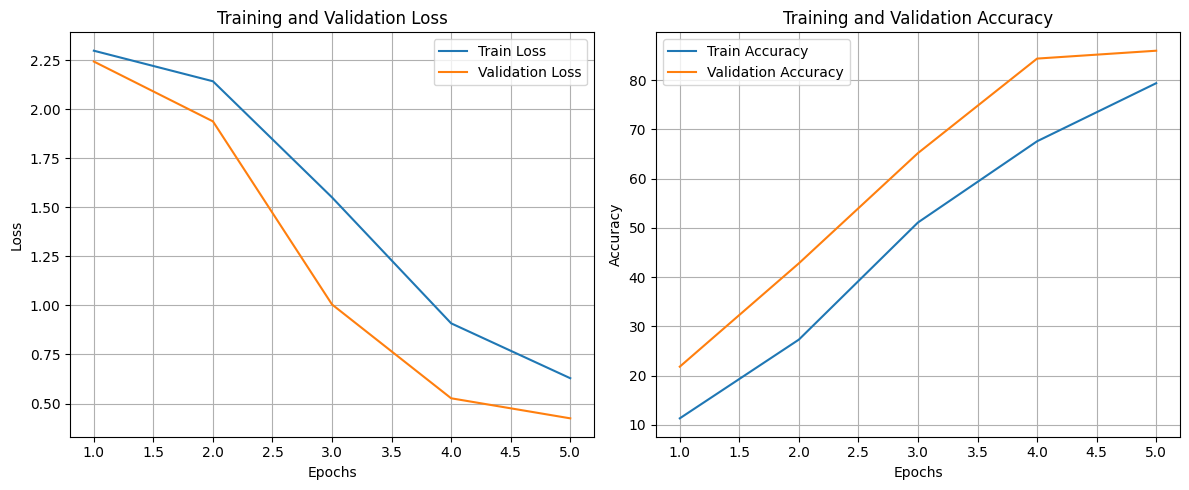

In [11]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.40%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

Executando experimento com 6 filtros em conv1 e 12 filtros em conv2.


100%|██████████| 16/16 [00:00<00:00, 21.84it/s]


Epoch 1, Train Loss: 2.253, Train Accuracy: 17.00%
Epoch 1, Val Loss: 2.121, Val Accuracy: 29.80%


100%|██████████| 16/16 [00:00<00:00, 22.40it/s]


Epoch 2, Train Loss: 1.817, Train Accuracy: 41.30%
Epoch 2, Val Loss: 1.278, Val Accuracy: 69.60%


100%|██████████| 16/16 [00:00<00:00, 22.11it/s]


Epoch 3, Train Loss: 1.003, Train Accuracy: 66.30%
Epoch 3, Val Loss: 0.564, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Epoch 4, Train Loss: 0.568, Train Accuracy: 80.80%
Epoch 4, Val Loss: 0.401, Val Accuracy: 87.80%


100%|██████████| 16/16 [00:00<00:00, 22.38it/s]


Epoch 5, Train Loss: 0.382, Train Accuracy: 88.20%
Epoch 5, Val Loss: 0.377, Val Accuracy: 88.40%
Treinamento concluído


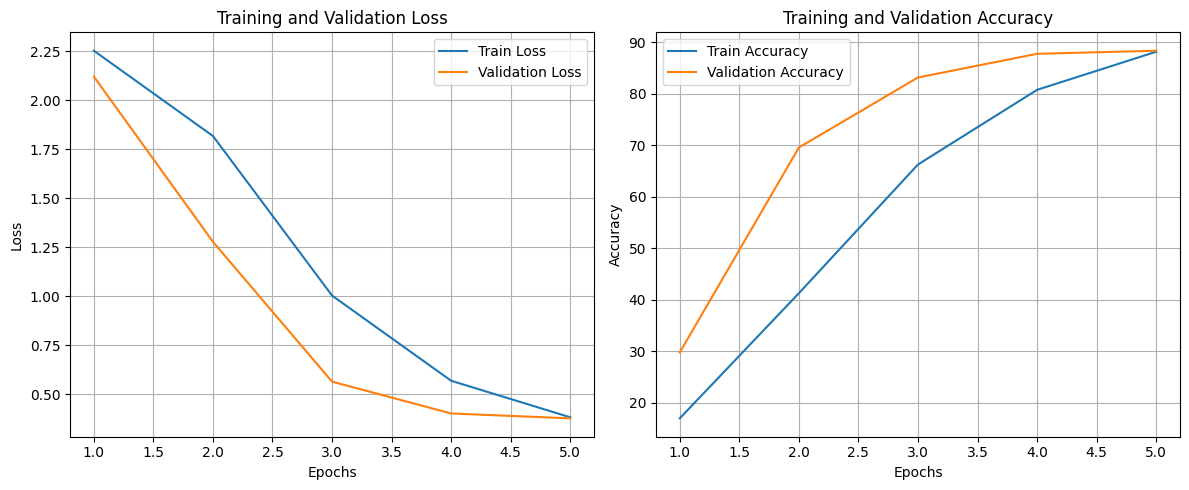

Acurácia da rede na base de teste: 90.20%
Executando experimento com 6 filtros em conv1 e 16 filtros em conv2.


100%|██████████| 16/16 [00:00<00:00, 22.26it/s]


Epoch 1, Train Loss: 2.247, Train Accuracy: 21.40%
Epoch 1, Val Loss: 2.109, Val Accuracy: 38.40%


100%|██████████| 16/16 [00:00<00:00, 22.92it/s]


Epoch 2, Train Loss: 1.840, Train Accuracy: 40.50%
Epoch 2, Val Loss: 1.397, Val Accuracy: 55.20%


100%|██████████| 16/16 [00:00<00:00, 23.06it/s]


Epoch 3, Train Loss: 1.168, Train Accuracy: 60.60%
Epoch 3, Val Loss: 0.771, Val Accuracy: 76.80%


100%|██████████| 16/16 [00:00<00:00, 17.36it/s]


Epoch 4, Train Loss: 0.733, Train Accuracy: 76.10%
Epoch 4, Val Loss: 0.548, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 16.04it/s]


Epoch 5, Train Loss: 0.531, Train Accuracy: 83.40%
Epoch 5, Val Loss: 0.431, Val Accuracy: 87.00%
Treinamento concluído


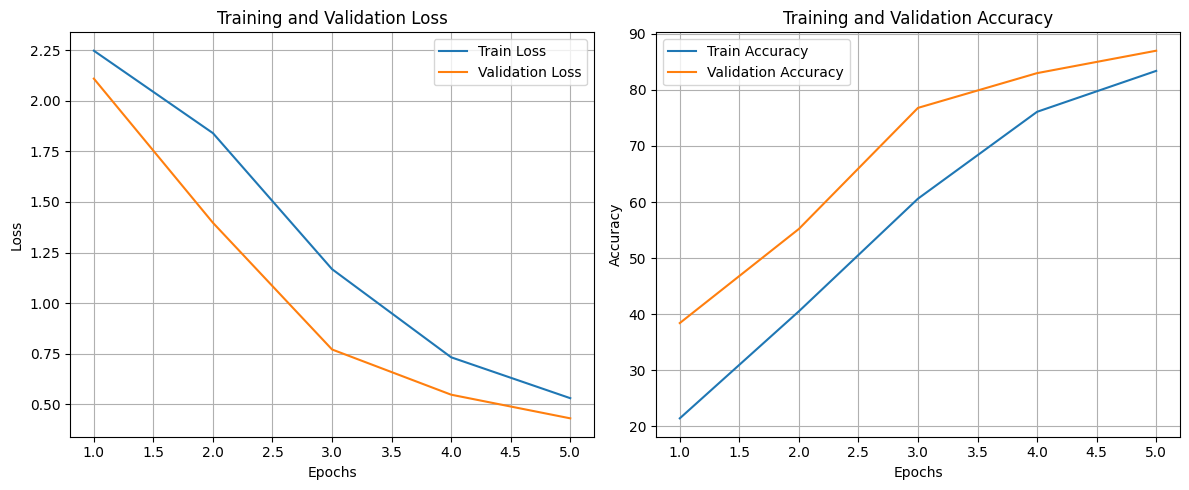

Acurácia da rede na base de teste: 86.20%
Executando experimento com 8 filtros em conv1 e 12 filtros em conv2.


100%|██████████| 16/16 [00:00<00:00, 22.07it/s]


Epoch 1, Train Loss: 2.248, Train Accuracy: 16.80%
Epoch 1, Val Loss: 2.105, Val Accuracy: 38.40%


100%|██████████| 16/16 [00:00<00:00, 21.42it/s]


Epoch 2, Train Loss: 1.835, Train Accuracy: 42.10%
Epoch 2, Val Loss: 1.258, Val Accuracy: 62.80%


100%|██████████| 16/16 [00:00<00:00, 20.05it/s]


Epoch 3, Train Loss: 1.102, Train Accuracy: 64.00%
Epoch 3, Val Loss: 0.645, Val Accuracy: 78.00%


100%|██████████| 16/16 [00:00<00:00, 21.69it/s]


Epoch 4, Train Loss: 0.642, Train Accuracy: 77.70%
Epoch 4, Val Loss: 0.480, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:00<00:00, 22.40it/s]


Epoch 5, Train Loss: 0.473, Train Accuracy: 84.50%
Epoch 5, Val Loss: 0.425, Val Accuracy: 86.00%
Treinamento concluído


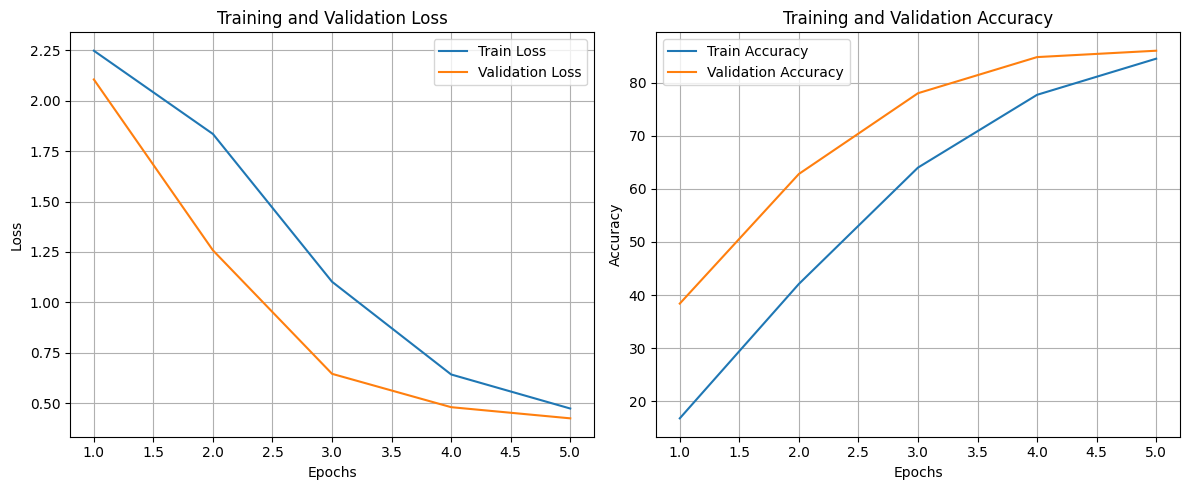

Acurácia da rede na base de teste: 85.00%
Executando experimento com 8 filtros em conv1 e 16 filtros em conv2.


100%|██████████| 16/16 [00:00<00:00, 20.80it/s]


Epoch 1, Train Loss: 2.257, Train Accuracy: 17.20%
Epoch 1, Val Loss: 2.120, Val Accuracy: 39.60%


100%|██████████| 16/16 [00:00<00:00, 20.71it/s]


Epoch 2, Train Loss: 1.897, Train Accuracy: 38.80%
Epoch 2, Val Loss: 1.370, Val Accuracy: 66.40%


100%|██████████| 16/16 [00:00<00:00, 20.92it/s]


Epoch 3, Train Loss: 1.129, Train Accuracy: 63.90%
Epoch 3, Val Loss: 0.583, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 16.98it/s]


Epoch 4, Train Loss: 0.693, Train Accuracy: 76.90%
Epoch 4, Val Loss: 0.441, Val Accuracy: 85.80%


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


Epoch 5, Train Loss: 0.493, Train Accuracy: 84.60%
Epoch 5, Val Loss: 0.384, Val Accuracy: 88.00%
Treinamento concluído


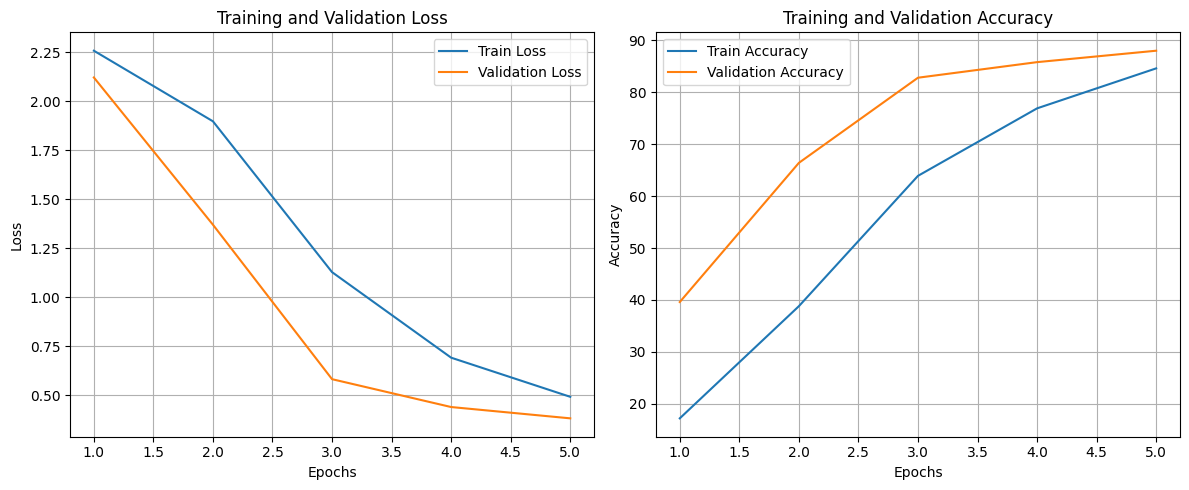

Acurácia da rede na base de teste: 86.20%


In [14]:
class CNN(nn.Module):
    def __init__(self, num_filters1=6, num_filters2=12, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters1, 5)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, 5)
        self.fc1 = nn.Linear(num_filters2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Função para treinar e testar o modelo com diferentes filtros
def run_experiment(num_filters1, num_filters2):
    print(f"Executando experimento com {num_filters1} filtros em conv1 e {num_filters2} filtros em conv2.")
    model = CNN(num_filters1=num_filters1, num_filters2=num_filters2, initialize_weights=True, dropout=0.2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(model=model, trainloader=trainloader, valloader=valloader, criterion=criterion, optimizer=optimizer)

    # Plotando os gráficos
    epochs = range(1, len(history['train_losses']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.grid()
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.grid()
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Testando a CNN
    test_model(model, testloader)

# Executando experimentos com diferentes combinações de filtros
experiments = [(6, 12), (6, 16), (8, 12), (8, 16)]

for num_filters1, num_filters2 in experiments:
    run_experiment(num_filters1, num_filters2)


Conclusão:
A combinação de 6 filtros em conv1 e 12 filtros em conv2 apresentou o melhor desempenho com uma acurácia de 90.20% no conjunto de teste. As demais combinações tiveram desempenhos levemente inferiores.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [15]:
class CNN(nn.Module):
    def __init__(self, fc1_neurons=64, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)

        # Modifiquei o número de neurônios na camada fc1
        self.fc1 = nn.Linear(12 * 4 * 4, fc1_neurons)
        self.fc2 = nn.Linear(fc1_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Função para rodar o experimento
def run_experiment(fc1_neurons):
    print(f"Executando experimento com {fc1_neurons} neurônios em fc1")

    # Instanciando o modelo com o número de neurônios variado
    model = CNN(fc1_neurons=fc1_neurons, initialize_weights=True, dropout=0.2)

    # Configurando a loss function e o otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando o modelo
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=5
    )

    # Testando o modelo
    test_model(model, testloader)

    return history


In [16]:
fc1_neurons_list = [32, 64, 128, 256, 512]

# Armazenar os históricos de treinamento
experiment_results = []

for neurons in fc1_neurons_list:
    history = run_experiment(fc1_neurons=neurons)
    experiment_results.append((neurons, history))


Executando experimento com 32 neurônios em fc1


100%|██████████| 16/16 [00:00<00:00, 20.78it/s]


Epoch 1, Train Loss: 2.302, Train Accuracy: 11.40%
Epoch 1, Val Loss: 2.246, Val Accuracy: 18.40%


100%|██████████| 16/16 [00:00<00:00, 22.11it/s]


Epoch 2, Train Loss: 2.143, Train Accuracy: 22.10%
Epoch 2, Val Loss: 1.910, Val Accuracy: 36.00%


100%|██████████| 16/16 [00:00<00:00, 22.52it/s]


Epoch 3, Train Loss: 1.645, Train Accuracy: 42.50%
Epoch 3, Val Loss: 1.050, Val Accuracy: 74.60%


100%|██████████| 16/16 [00:00<00:00, 21.91it/s]


Epoch 4, Train Loss: 0.960, Train Accuracy: 69.20%
Epoch 4, Val Loss: 0.607, Val Accuracy: 82.00%


100%|██████████| 16/16 [00:00<00:00, 22.34it/s]


Epoch 5, Train Loss: 0.673, Train Accuracy: 76.60%
Epoch 5, Val Loss: 0.449, Val Accuracy: 87.60%
Treinamento concluído
Acurácia da rede na base de teste: 88.40%
Executando experimento com 64 neurônios em fc1


100%|██████████| 16/16 [00:01<00:00, 15.83it/s]


Epoch 1, Train Loss: 2.334, Train Accuracy: 13.50%
Epoch 1, Val Loss: 2.237, Val Accuracy: 28.80%


100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Epoch 2, Train Loss: 2.154, Train Accuracy: 29.80%
Epoch 2, Val Loss: 1.981, Val Accuracy: 35.20%


100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


Epoch 3, Train Loss: 1.674, Train Accuracy: 44.50%
Epoch 3, Val Loss: 1.208, Val Accuracy: 61.80%


100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


Epoch 4, Train Loss: 1.094, Train Accuracy: 60.80%
Epoch 4, Val Loss: 0.728, Val Accuracy: 79.00%


100%|██████████| 16/16 [00:00<00:00, 23.00it/s]


Epoch 5, Train Loss: 0.745, Train Accuracy: 75.10%
Epoch 5, Val Loss: 0.527, Val Accuracy: 83.60%
Treinamento concluído
Acurácia da rede na base de teste: 83.80%
Executando experimento com 128 neurônios em fc1


100%|██████████| 16/16 [00:00<00:00, 21.82it/s]


Epoch 1, Train Loss: 2.294, Train Accuracy: 17.90%
Epoch 1, Val Loss: 2.178, Val Accuracy: 34.60%


100%|██████████| 16/16 [00:00<00:00, 21.53it/s]


Epoch 2, Train Loss: 1.908, Train Accuracy: 41.70%
Epoch 2, Val Loss: 1.397, Val Accuracy: 59.40%


100%|██████████| 16/16 [00:00<00:00, 22.56it/s]


Epoch 3, Train Loss: 1.025, Train Accuracy: 66.80%
Epoch 3, Val Loss: 0.620, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 19.41it/s]


Epoch 4, Train Loss: 0.550, Train Accuracy: 81.90%
Epoch 4, Val Loss: 0.425, Val Accuracy: 85.80%


100%|██████████| 16/16 [00:00<00:00, 16.31it/s]


Epoch 5, Train Loss: 0.420, Train Accuracy: 85.00%
Epoch 5, Val Loss: 0.391, Val Accuracy: 88.80%
Treinamento concluído
Acurácia da rede na base de teste: 90.60%
Executando experimento com 256 neurônios em fc1


100%|██████████| 16/16 [00:01<00:00, 13.48it/s]


Epoch 1, Train Loss: 2.277, Train Accuracy: 14.30%
Epoch 1, Val Loss: 2.137, Val Accuracy: 34.80%


100%|██████████| 16/16 [00:00<00:00, 21.90it/s]


Epoch 2, Train Loss: 1.808, Train Accuracy: 46.20%
Epoch 2, Val Loss: 1.235, Val Accuracy: 60.60%


100%|██████████| 16/16 [00:00<00:00, 21.67it/s]


Epoch 3, Train Loss: 0.929, Train Accuracy: 68.90%
Epoch 3, Val Loss: 0.649, Val Accuracy: 76.60%


100%|██████████| 16/16 [00:00<00:00, 22.16it/s]


Epoch 4, Train Loss: 0.576, Train Accuracy: 81.60%
Epoch 4, Val Loss: 0.458, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 22.63it/s]


Epoch 5, Train Loss: 0.384, Train Accuracy: 87.50%
Epoch 5, Val Loss: 0.423, Val Accuracy: 86.00%
Treinamento concluído
Acurácia da rede na base de teste: 88.20%
Executando experimento com 512 neurônios em fc1


100%|██████████| 16/16 [00:00<00:00, 22.23it/s]


Epoch 1, Train Loss: 2.275, Train Accuracy: 15.80%
Epoch 1, Val Loss: 2.145, Val Accuracy: 32.00%


100%|██████████| 16/16 [00:00<00:00, 21.81it/s]


Epoch 2, Train Loss: 1.776, Train Accuracy: 48.60%
Epoch 2, Val Loss: 1.055, Val Accuracy: 72.40%


100%|██████████| 16/16 [00:00<00:00, 21.79it/s]


Epoch 3, Train Loss: 0.744, Train Accuracy: 76.10%
Epoch 3, Val Loss: 0.517, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 21.76it/s]


Epoch 4, Train Loss: 0.376, Train Accuracy: 86.80%
Epoch 4, Val Loss: 0.377, Val Accuracy: 88.60%


100%|██████████| 16/16 [00:00<00:00, 22.02it/s]


Epoch 5, Train Loss: 0.279, Train Accuracy: 90.90%
Epoch 5, Val Loss: 0.366, Val Accuracy: 90.00%
Treinamento concluído
Acurácia da rede na base de teste: 91.40%


In [17]:
for neurons, history in experiment_results:
    print(f"\nResultados para {neurons} neurônios em fc1:")
    print(f"Última acurácia de treino: {history['train_accuracies'][-1]:.2f}%")
    print(f"Última acurácia de validação: {history['val_accuracies'][-1]:.2f}%")



Resultados para 32 neurônios em fc1:
Última acurácia de treino: 76.60%
Última acurácia de validação: 87.60%

Resultados para 64 neurônios em fc1:
Última acurácia de treino: 75.10%
Última acurácia de validação: 83.60%

Resultados para 128 neurônios em fc1:
Última acurácia de treino: 85.00%
Última acurácia de validação: 88.80%

Resultados para 256 neurônios em fc1:
Última acurácia de treino: 87.50%
Última acurácia de validação: 86.00%

Resultados para 512 neurônios em fc1:
Última acurácia de treino: 90.90%
Última acurácia de validação: 90.00%
